Training Model...
Training Complete.

----------------------------------------
Test Runner [Speed: 25 km/h, Ammo: 1]
Survival Probability: 1.0000
Prediction: SURVIVE (1)
----------------------------------------


/tmp/ipython-input-916386533.py:150: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(infected[:, 0], infected[:, 1], color='red', label='Infected (0)', s=80, edgecolors='k', marker='x')


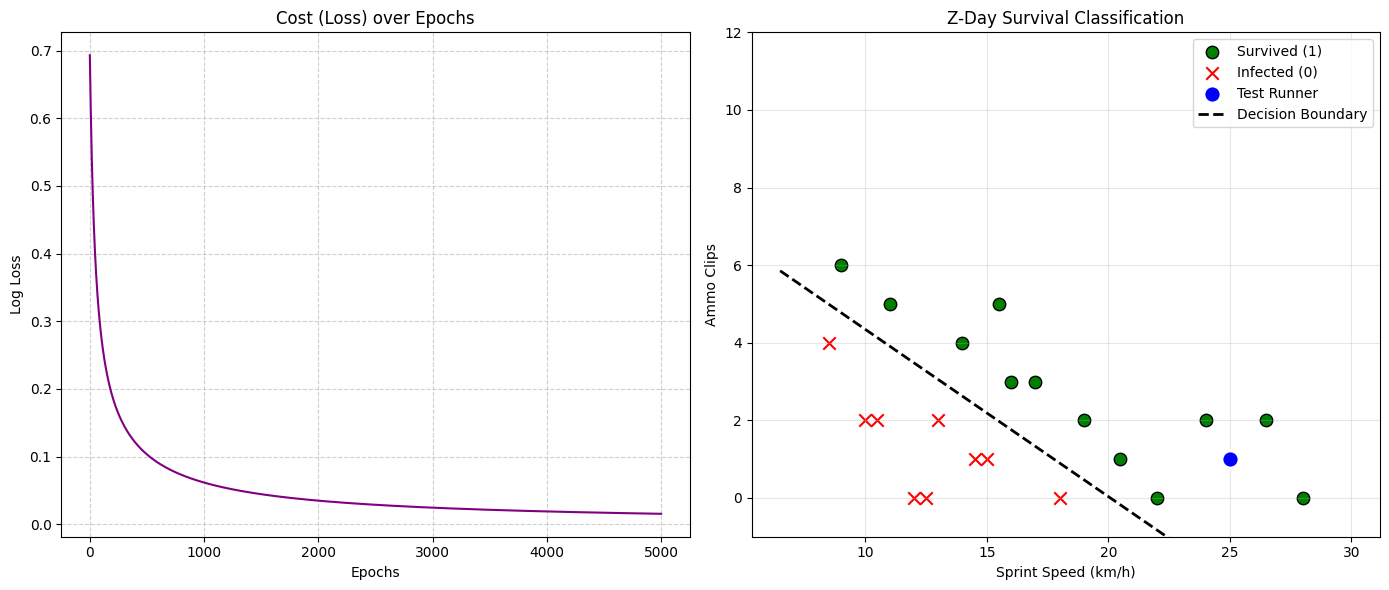

In [2]:
# ==========================================
# 2. DATA PROCESSING (Manual Reading & Normalization)
import numpy as np
import matplotlib.pyplot as plt
# ==========================================
filename = 'zombies_data.csv'

raw_data = [
    ["SprintSpeed", "AmmoClips", "Result"],
    [12, 0, 0],
    [14.5, 1, 0],
    [10, 2, 0],
    [18, 0, 0],
    [8.5, 4, 0],
    [15, 1, 0],
    [22, 0, 1],
    [11, 5, 1],
    [13, 2, 0],
    [20.5, 1, 1],
    [24, 2, 1],
    [16, 3, 1],
    [12.5, 0, 0],
    [28, 0, 1],
    [9, 6, 1],
    [25, 1, 1],
    [14, 4, 1],
    [19, 2, 1],
    [10.5, 2, 0],
    [26.5, 2, 1],
    [15.5, 5, 1],
    [17, 3, 1]
]
def load_and_process_data(filename):
    X_raw = []
    y_raw = []

    with open(filename, 'r') as f:
        header = next(f) # Skip header
        for line in f:
            parts = line.strip().split(',')
            # Parse features: [Speed, Ammo]
            X_raw.append([float(parts[0]), float(parts[1])])
            # Parse label: Status
            y_raw.append(int(parts[2]))

    X = np.array(X_raw)
    Y = np.array(y_raw)
    return X, Y

X, Y = load_and_process_data(filename)

# Feature Normalization (Z-Score Standardization)
# Crucial because Speed (10-35) and Ammo (0-10) have different scales.
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)

X_norm = (X - mean) / std

# Add Bias term (column of 1s) to X for matrix multiplication
m_samples = len(X)
X_b = np.c_[np.ones((m_samples, 1)), X_norm] # X_b shape: (m, 3)


# ==========================================
# 3. LOGISTIC REGRESSION MODEL
# ==========================================
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def train_logistic_regression(X, y, lr=0.1, epochs=5000):
    m = len(y)
    n_features = X.shape[1]

    # Initialize weights (w) and bias is included in theta[0] due to X_b
    theta = np.zeros(n_features)
    cost_history = []

    for i in range(epochs):
        # 1. Linear combination (z = theta^T * x)
        z = np.dot(X, theta)

        # 2. Activation (Predictions)
        y_pred = sigmoid(z)

        # 3. Cost Function (Log Loss)
        # Add epsilon to avoid log(0) error
        epsilon = 1e-15
        cost = (-1/m) * np.sum(y * np.log(y_pred + epsilon) + (1 - y) * np.log(1 - y_pred + epsilon))
        cost_history.append(cost)

        # 4. Gradient Calculation
        gradient = (1/m) * np.dot(X.T, (y_pred - y))

        # 5. Update Weights
        theta -= lr * gradient

    return theta, cost_history

# Train
print("Training Model...")
theta, costs = train_logistic_regression(X_b, Y, lr=0.1, epochs=5000)
print("Training Complete.\n")


# ==========================================
# 4. OUTPUT 1: TEST PREDICTION
# ==========================================
# Runner: 25 km/h, 1 Ammo Clip
runner_raw = np.array([25, 1])

# We must normalize this new data using the TRAINING statistics
runner_norm = (runner_raw - mean) / std

# Add bias term (1)
runner_final = np.r_[1, runner_norm]

# Predict
z_score = np.dot(runner_final, theta)
probability = sigmoid(z_score)
prediction = 1 if probability >= 0.5 else 0
label = "SURVIVE" if prediction == 1 else "INFECTED"

print("-" * 40)
print(f"Test Runner [Speed: 25 km/h, Ammo: 1]")
print(f"Survival Probability: {probability:.4f}")
print(f"Prediction: {label} ({prediction})")
print("-" * 40)


# ==========================================
# 5. VISUALIZATION
# ==========================================
plt.figure(figsize=(14, 6))

# --- Plot 1: Cost History ---
plt.subplot(1, 2, 1)
plt.plot(costs, color='purple')
plt.title('Cost (Loss) over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.grid(True, linestyle='--', alpha=0.6)

# --- Plot 2: Decision Boundary ---
plt.subplot(1, 2, 2)

# Scatter plot of actual data
survived = X[Y == 1]
infected = X[Y == 0]
plt.scatter(survived[:, 0], survived[:, 1], color='green', label='Survived (1)', s=80, edgecolors='k')
plt.scatter(infected[:, 0], infected[:, 1], color='red', label='Infected (0)', s=80, edgecolors='k', marker='x')

# Plot Test Runner
plt.scatter(25, 1, color='blue', s=150, label='Test Runner', zorder=5, edgecolors='white', linewidth=2)

# Calculate Decision Boundary Line
# The boundary is where theta0 + theta1*x1_norm + theta2*x2_norm = 0
# We want to plot x2 (Ammo) vs x1 (Speed) in ORIGINAL scale.
# x1_norm = (x1 - mean[0]) / std[0]
# x2_norm = (x2 - mean[1]) / std[1]
# Solve for x2:

x1_min, x1_max = X[:, 0].min() - 2, X[:, 0].max() + 2
x1_values = np.linspace(x1_min, x1_max, 100)

# Formula derived by substituting normalized terms back into line equation:
# theta[0] + theta[1]*((x1 - mu1)/s1) + theta[2]*((x2 - mu2)/s2) = 0
# x2 = mu2 - (s2/theta[2]) * (theta[0] + theta[1]*((x1 - mu1)/s1))

theta0, theta1, theta2 = theta
mu1, mu2 = mean
s1, s2 = std

boundary_y = mu2 - (s2 / theta2) * (theta0 + theta1 * ((x1_values - mu1) / s1))

plt.plot(x1_values, boundary_y, color='black', linewidth=2, linestyle='--', label='Decision Boundary')

plt.title('Z-Day Survival Classification')
plt.xlabel('Sprint Speed (km/h)')
plt.ylabel('Ammo Clips')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(-1, 12) # Limit y-axis for better visibility

plt.tight_layout()
plt.show()